In [1]:
# PYTHON LIBRARIES
%matplotlib inline

import math
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.rc('xtick', labelsize=15)     
plt.rc('ytick', labelsize=15)
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
number = LabelEncoder()
from statsmodels.stats.outliers_influence import summary_table
from adjustText import adjust_text

# Adjust css for usability
from IPython.core.display import HTML
HTML('''
<style type="text/css">

.jp-RenderedHTMLCommon table {
    table-layout: auto;
    border-collapse: collapse;
    width: 75%;
}

.jp-RenderedHTMLCommon table .absorbing-column {
    width: 75%;
}

</style>
''')

## Function to compute and plot a cubic regression

In [2]:
def magnitude(value):
    if (value == 0): return 0
    return 10**(int(math.floor(math.log10(abs(value)))))

In [3]:
def scatterPlot(x_str, x_units, y_str, y_units, df, fig_name):
    # PLOT FIG
    scale = 6;
    fig, ax = plt.subplots(figsize=(3*scale, 2*scale));

    # sort values by the independent variable
    df_x = df.sort_values(by=[x_str])
    # remove NANs from both variables and store them
    df_x = df_x.dropna(subset=[x_str, y_str])
    x = df_x.iloc[:][x_str]
    y = df_x.iloc[:][y_str]

    # Plot
    plt.scatter(x, y, s=25)
    
    # Display plots
    plt.yscale('linear');
    plt.xlabel(x_str + '    ' + x_units, fontsize=24);
    plt.ylabel(y_str + '    ' + y_units, fontsize=24);
    plt.title(fig_name, size=24);
    #plt.legend(prop={'size': 18});
    #plt.ticklabel_format(axis='both', style='sci', scilimits=(-2,2))
    plt.show();

In [20]:
def scatterPlot_breakAxis(x_str, x_units, y_str, y_units, df, df_x, fig_name, breakYlim):
    
    # GET THE X Y VALUES
    # sort values by the independent variable
    df_xx = df_x.sort_values(by=[y_str])
    # remove NANs from both variables and store them
    df_xx = df_x.dropna(subset=[x_str, y_str])
    x = df_xx.iloc[:][x_str]
    y = df_xx.iloc[:][y_str]
    
    # GET THE REFERENCE STRING VALUES FOR PLOT ANNOTATIONS
    ref = df.iloc[:]['Reference']
    
    # CREATE A NEW DATAFRAME WITH THE INTERESTING DATA ONLY
    # IN ORDER TO EFFECTIVELY REMOVE DUPLICATES
    new_df = pd.DataFrame(x)
    new_df = new_df.join(pd.DataFrame(y))
    new_df = new_df.join(pd.DataFrame(ref))
    
    # Drop duplicate values 
    new_df = new_df.drop_duplicates()
    # sort values by the independent variable
    new_df = new_df.sort_values(by=[y_str])
    
    # Print the interesting data
    print('>>> new_df')
    print(new_df)
    
    # Extract the interesting data frame into individual
    # panda series
    x   = new_df.iloc[:][x_str]
    y   = new_df.iloc[:][y_str]
    ref = new_df.iloc[:]['Reference']
    
    # PLOT SETUP
    scale = 6;
    fig = plt.figure(figsize=(3*scale, 2*scale))
    
    # Inplement a 3rows-1column grid to plot an "axis break" 
    grid = plt.GridSpec(3, 1, wspace=0.4)
    ax0 = fig.add_subplot(grid[0, 0]);  # TOP part
    ax1 = fig.add_subplot(grid[1:, 0]); # BOTTOM part

    # Use breakYlim to split the data and plot accordingly
    # on each subplot
    ax0.scatter(x[breakYlim:], y[breakYlim:], s=50)
    ax1.scatter(x[:breakYlim], y[:breakYlim], s=50)
    
    # zoom-in / limit the view to different portions of the data

    # ZOOM-IN AND LIMIT THE VIEW TO DIFFERENT PORTIONS OF THE DATA
    dy_top = magnitude(max(y)-y.values[breakYlim])/10
    dy_bot = magnitude(y.values[breakYlim]-min(y))/10
    dx = magnitude(max(x)-min(x))
    
    # same x-axis limits for all subplots to be consistent with scaling
    ax0.set_xlim(min(x)-dx, max(x)+dx)
    ax1.set_xlim(min(x)-dx, max(x)+dx)
    
    # y-limits for the TOP part
    ax0.set_ylim(y.values[breakYlim]-dy_top, max(y)+dy_top)
    
    # y-limits for the BOTTOM part
    ax1.set_ylim(min(y)-dy_bot, y.values[breakYlim-1]+dy_bot)
    
    # hide the spines and axis between ax0 and ax1
    ax0.spines['bottom'].set_visible(False) # hide bottom border
    ax0.axes.get_xaxis().set_visible(False) # hide xaxis labels
    ax1.spines['top'].set_visible(False)
    ax1.xaxis.tick_bottom()
    
    ax0.yaxis.get_major_ticks()[1].label1.set_visible(False)

    # FORMAT THE AXIS BREAK GRAPHICS
    d = .0075; # how big to make the diagonal lines in axes coordinates
    d0 = d*2;  # add some offset to have the same inclination on all diagonals
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax0.transAxes, color='k', clip_on=False)
    # draw top-left diagonal
    ax0.plot((0-d, 0+d), (0-d0, 0+d0), **kwargs)
    # draw top-right diagonal
    ax0.plot((1-d, 1+d), (0-d0, 0+d0), **kwargs)
    kwargs.update(transform=ax1.transAxes)  # switch to the bottom axes
    # draw bottom-left diagonal
    ax1.plot((0-d, 0+d), (1-d, 1+d), **kwargs)
    # draw bottom-right diagonal
    ax1.plot((1-d, 1+d), (1-d, 1+d), **kwargs)

    # Vary the distance between ax0 and ax1
    fig.subplots_adjust(hspace=0.1)

    # GROUP ALL SUBPLOTS TO ADD FURTHER FORMATTING
    # add a big axis to group all, and hide its frame
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

    # Display plots
    plt.xlabel(x_str + '    ' + x_units, fontsize=24);
    ax0.set_ylabel(y_str + '    ' + y_units, fontsize=24)
    ax0.yaxis.set_label_coords(-0.06, 0)
    plt.title(fig_name, size=24);
    # add annotations (references on aech point)
    texts = []
    for xs, ys, ss in zip(x[breakYlim:], y[breakYlim:], ref[breakYlim:]):
        texts.append(ax0.text(xs, ys, str(ss), fontsize=15))
    for xs, ys, ss in zip(x[:breakYlim], y[:breakYlim], ref[:breakYlim]):
        texts.append(ax1.text(xs, ys, str(ss), fontsize=15))
    # avoid overlaps between annotations
    adjust_text(texts)  
    plt.show()

# NFESdata.csv description:

<table align="center">
    <tr>
        <th><b>Parameter_Name</b></th>
        <th><b>Parameter_Units</b></th>
        <th><b>Data_Type</b></th>
        <th class="absorbing-column"><b>Description</b></th>
    </tr>
    <tr>
        <td><b>Polymer</b></td>
        <td>$N/A$</td>
        <td>string</td>
        <td>polymer used in the NFES solution</td>
    </tr>
    <tr>
        <td><b>Polymer Molecular Weight</b></td>
        <td>$g \cdot {mol}^{-1}$</td>
        <td>float</td>
        <td>polymer molecular weight</td>
    </tr>
    <tr>
        <td><b>Solvent</b></td>
        <td>$N/A$</td>
        <td>string</td>
        <td>solvent used in the NFES solution</td>
    </tr>
    <tr>
        <td><b>Solvent Surface Tension</b></td>
        <td>$mN \cdot m^{-1}$</td>
        <td>float</td>
        <td>solvent surface tension at $298.2 K$ and $101325 Pa$</td>
    </tr>
    <tr>
        <td><b>Solvent Dielectric Constant</b></td>
        <td>$N/A$</td>
        <td>float</td>
        <td>solvent dielectric constant at $298.2 K$</td>
    </tr>
    <tr>
        <td><b>Solvent Boiling Point</b></td>
        <td>$^{\circ} C$</td>
        <td>float</td>
        <td>solvent boiling point</td>
    </tr>
    <tr>
        <td><b>Solvent Density</b></td>
        <td>$g \cdot ml^{-1}$</td>
        <td>float</td>
        <td>solvent relative density (water = 1) at $293.15 K$</td>
    </tr>
    <tr>
        <td><b>Solvent Vapour Pressure</b></td>
        <td>$kPa$</td>
        <td>float</td>
        <td>solvent vapour pressure at $293.15 K$</td>
    </tr>
    <tr>
        <td><b>NFES Type</b></td>
        <td>$N/A$</td>
        <td>string</td>
        <td>NFES process type/variant implemented in [reference]</td>
    </tr>
    <tr>
        <td><b>Polymer Concentration</b></td>
        <td>$wt\%$</td>
        <td>float</td>
        <td>polymer concentration used in the NFES solution</td>
    </tr>
    <tr>
        <td><b>Nozzle Diameter</b></td>
        <td>$\mu m$</td>
        <td>float</td>
        <td>inner diameter of the dispensing nozzle</td>
    </tr>
    <tr>
        <td><b>Solution Deposition Rate</b></td>
        <td>$\mu L \cdot h^{-1}$</td>
        <td>float</td>
        <td>rate at which the solution is dispensed from the reservoir</td>
    </tr>
    <tr>
        <td><b>Collector Substrate</b></td>
        <td>$N/A$</td>
        <td>string</td>
        <td>composition of the collector</td>
    </tr>
    <tr>
        <td><b>Nozzle to Collector Distance</b></td>
        <td>$mm$</td>
        <td>float</td>
        <td>distance between the dispensing nozzle and the collector</td>
    </tr>
    <tr>
        <td><b>NFES Applied Voltage</b></td>
        <td>$V$</td>
        <td>float</td>
        <td>applied voltage between the dispensing nozzle and the collector during NFES</td>
    </tr>
    <tr>
        <td><b>NFES Stage Velocity</b></td>
        <td>$mm \cdot s^{-1}$</td>
        <td>float</td>
        <td>velocity at which the stage/collector moves with respect to the dispensing nozzle</td>
    </tr>
    <tr>
        <td><b>Fiber Diameter</b></td>
        <td>$nm$</td>
        <td>float</td>
        <td>diameter of the produced fibers</td>
    </tr>
    <tr>
        <td><b>Distance Between Fibers</b></td>
        <td>$\mu m$</td>
        <td>float</td>
        <td>minimum distance achieved between two parallel fibers</td>
    </tr>
    <tr>
        <td><b>Reference</b></td>
        <td>$N/A$</td>
        <td>string</td>
        <td>reference author name and publication year</td>
    </tr>
</table>

## Give strings a numeric value

In [5]:
df = pd.read_csv("./NFESdata.csv", delimiter=",");

# df.loc[<ROWS RANGE> , <COLUMNS RANGE>] to get elements by index

# Assign a numeric value to string data type values
df_x = df.copy();
for col in range(len(df.columns)):
    if str(type(df.iloc[0 , col])) == "<class 'str'>":
        df_x.iloc[: , col] = number.fit_transform(df.iloc[: , col].astype('str'))

## Print column name and its data type
#print()
#for col in range(len(df.columns)):
#    print(str(df.columns[col]) + ' ' + str(type(df.iloc[0 , col])))

display(df.head(df.size));
display(df_x.head());

,Polymer,Polymer Molecular Weight,Solvent,Solvent Surface Tension,Solvent Dielectric Constant,Solvent Boiling Point,Solvent Density,Solvent Vapour Pressure,NFES Type,Polymer Concentration,Nozzle Diameter,Solution Deposition Rate,Collector Substrate,Nozzle to Collector Distance,NFES Applied Voltage,NFES Stage Velocity,Fiber Diameter,Distance Between Fibers,Reference
0,Gelatin,NaN,AceticAcid,26.5555,6.1700,117.9710,1.0510,1.5200,NFES,11.00,NaN,NaN,PDMS,1.25,1000.0,NaN,2500.00,40.00,Xue 2014
1,PVDF,534000.0,Acetone,22.4998,20.9000,56.2645,0.7845,24.2270,3D ES,17.00,100.0,0.84,paper,0.75,1900.0,10.000,NaN,NaN,Kim 2018
2,POSS-PCU,2000.0,Butanol,24.1947,17.4849,117.7000,0.8098,0.5800,EHD jetting,20.00,750.0,60.00,NaN,1.25,9000.0,10.000,27500.00,250.00,Gupta 2007
3,POSS-PCL-PCU,2000.0,Butanol,24.1947,17.4849,117.7000,0.8098,0.5800,EHD jetting,20.00,750.0,60.00,NaN,1.25,9000.0,10.000,27500.00,250.00,Gupta 2007
4,POSS-PCU,2000.0,Dimethylacetamide DMAC,34.0000,23.0000,165.0000,0.9366,0.3300,EHD jetting,20.00,750.0,60.00,NaN,1.25,9000.0,10.000,27500.00,250.00,Gupta 2007
5,POSS-PCL-PCU,2000.0,Dimethylacetamide DMAC,34.0000,23.0000,165.0000,0.9366,0.3300,EHD jetting,20.00,750.0,60.00,NaN,1.25,9000.0,10.000,27500.00,250.00,Gupta 2007
6,PLGA,NaN,Dimethylcarbonate DMC,28.3000,3.0870,90.5000,1.0636,7.4000,TPES,NaN,NaN,NaN,PTFE,NaN,75000.0,NaN,304.70,NaN,Coppola 2014
7,PVDF,440000.0,Dimethylformamide DMF,36.4200,36.7000,152.8000,0.9445,0.4900,Helix EHD,18.00,260.0,24.00,PDMS,30.00,2250.0,6.667,2250.00,NaN,Duang 2017
8,PEO-TBF,4000000.0,Dimethylformamide DMF,36.4200,36.7000,152.8000,0.9445,0.4900,NFES,0.75,NaN,NaN,Brass,NaN,980.0,NaN,NaN,NaN,Cisquella-Serra 2019
9,PVDF,534000.0,Dimethylsulfoxide DMSO,42.8600,46.7000,189.0000,1.1010,0.0493,3D ES,17.00,100.0,0.84,paper,0.75,1900.0,10.000,NaN,NaN,Kim 2018


,Polymer,Polymer Molecular Weight,Solvent,Solvent Surface Tension,Solvent Dielectric Constant,Solvent Boiling Point,Solvent Density,Solvent Vapour Pressure,NFES Type,Polymer Concentration,Nozzle Diameter,Solution Deposition Rate,Collector Substrate,Nozzle to Collector Distance,NFES Applied Voltage,NFES Stage Velocity,Fiber Diameter,Distance Between Fibers,Reference
0,0,NaN,1,26.5555,6.1700,117.9710,1.0510,1.520,8,11.0,NaN,NaN,3,1.25,1000.0,NaN,2500.0,40.0,19
1,8,534000.0,2,22.4998,20.9000,56.2645,0.7845,24.227,0,17.0,100.0,0.84,9,0.75,1900.0,10.0,NaN,NaN,9
2,6,2000.0,3,24.1947,17.4849,117.7000,0.8098,0.580,3,20.0,750.0,60.00,8,1.25,9000.0,10.0,27500.0,250.0,6
3,5,2000.0,3,24.1947,17.4849,117.7000,0.8098,0.580,3,20.0,750.0,60.00,8,1.25,9000.0,10.0,27500.0,250.0,6
4,6,2000.0,4,34.0000,23.0000,165.0000,0.9366,0.330,3,20.0,750.0,60.00,8,1.25,9000.0,10.0,27500.0,250.0,6


# Correlation Matrix

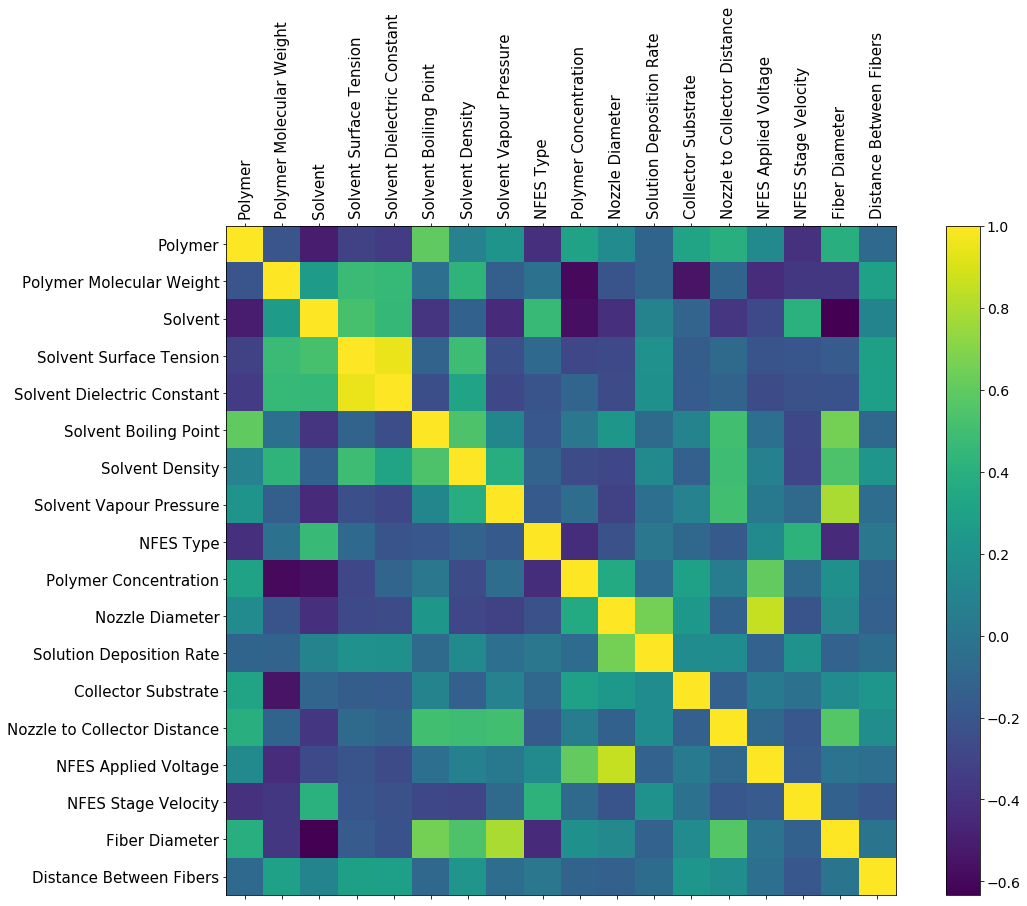

In [6]:
# all '-1's are to remove 'Reference' from the Correlation Matrix
scale = 6;
fig = plt.figure(figsize=(3*scale, 2*scale))
plt.matshow(df_x.iloc[:, :-1].corr(), fignum=fig.number)
plt.xticks(range(df_x.shape[1]-1), df_x.columns[:-1], rotation=90)
plt.yticks(range(df_x.shape[1]-1), df_x.columns[:-1], rotation=00)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
#plt.title('Correlation Matrix', fontsize=16);
plt.show()

In [7]:
# Multivariate Linear Regression
df_x = df.sort_values(by=['Fiber Diameter'])
df_x = df_x.dropna(subset=['Polymer Concentration','Nozzle Diameter','NFES Applied Voltage','Fiber Diameter'])

# X is the independent variable (bivariate in this case)
X = np.array([df_x.iloc[:]['Polymer Concentration'], df_x.iloc[:]['Nozzle Diameter'], df_x.iloc[:]['NFES Applied Voltage']])

# Y is the dependent data
Y = df_x.iloc[:]['Fiber Diameter']

# predict is an independent variable for which we'd like to predict the value
predict= [[20.0, 750.0, 9000.0]]

# generate a model of polynomial features
poly = PolynomialFeatures(degree=2)

# transform the x data for proper fitting (for single variable type it returns,[1,x,x**2])
X_ = poly.fit_transform(X)

# transform the prediction to fit the model type
predict_ = poly.fit_transform(predict)

# generate the regression object
clf = LinearRegression()

# perform the actual regression
clf = clf.fit(np.transpose(X), Y)

print('\n')
print('>>> INTERCEPT & COEFFICIENTS')
print(clf.intercept_)
print(clf.coef_)
print('\n')
print('>>> PREDICTION')
print("Prediction = " + str(clf.predict(predict)))
print('\n')



>>> INTERCEPT & COEFFICIENTS
10397.937792039389
[-324.59076316  -44.07990021    5.69273164]


>>> PREDICTION
Prediction = [22080.78214966]




>>> new_df
    NFES Applied Voltage  Fiber Diameter     Reference
31                 800.0           61.00    Chang 2008
21                1300.0          100.00  Camillo 2013
30                 300.0          237.00    Bisht 2011
19                3500.0          289.26      Min 2013
40                1600.0          300.00    Nagle 2019
7                 2250.0         2250.00    Duang 2017
10                2000.0         3730.00    Jiang 2018
12                1700.0         5150.00    Zheng 2010
39                3000.0        25000.00    Zheng 2014
5                 9000.0        27500.00    Gupta 2007
20                 450.0       115000.00     Song 2015


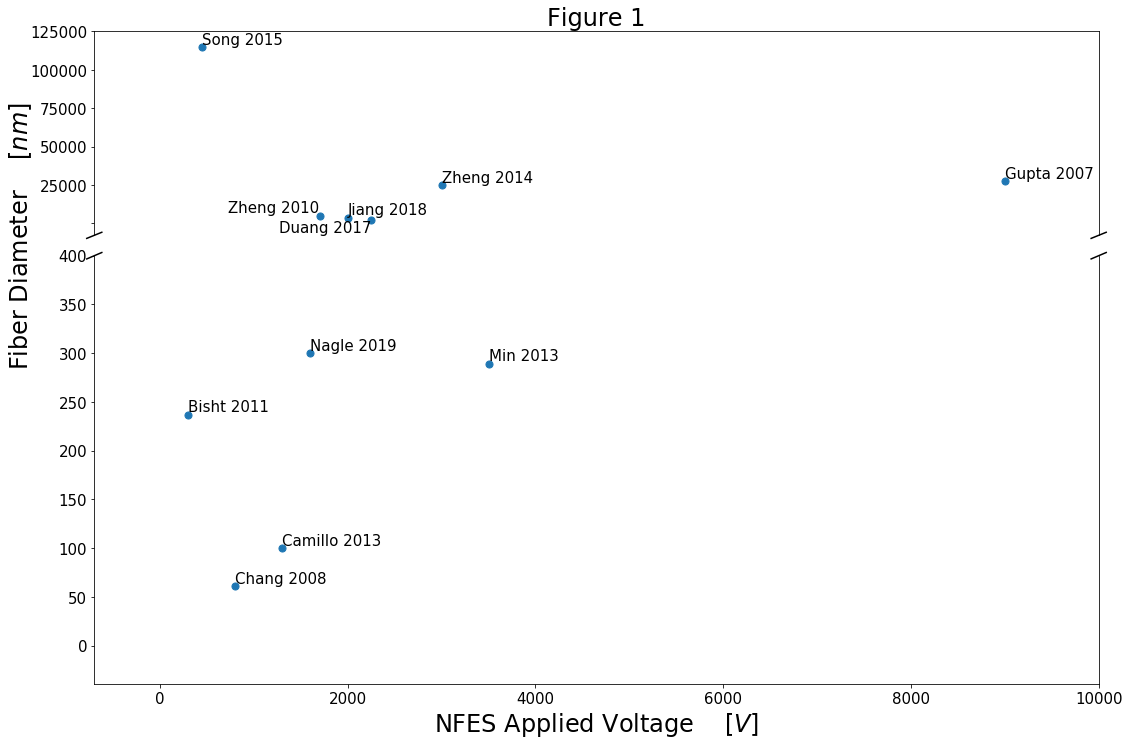

In [24]:
# PLOT FIG
fig_name = 'Figure 1';
x_str = 'NFES Applied Voltage'; x_units = r'$[V]$';
y_str = 'Fiber Diameter'; y_units = r'$[nm]$';
breakYlim = 5;

scatterPlot_breakAxis(x_str, x_units, y_str, y_units, df, df_x, fig_name, breakYlim);
#scatterPlot(x_str, x_units, y_str, y_units, df, 'original: ' + fig_name)

>>> new_df
    Polymer Concentration  Fiber Diameter     Reference
31                   7.00           61.00    Chang 2008
21                   0.08          100.00  Camillo 2013
30                   3.00          237.00    Bisht 2011
29                   2.00          237.00    Bisht 2011
28                   1.00          237.00    Bisht 2011
19                   3.96          289.26      Min 2013
40                  14.00          300.00    Nagle 2019
7                   18.00         2250.00    Duang 2017
10                   8.00         3730.00    Jiang 2018
12                  18.00         5150.00    Zheng 2010
11                  16.00         5150.00    Zheng 2010
39                  14.00        25000.00    Zheng 2014
5                   20.00        27500.00    Gupta 2007
20                   3.00       115000.00     Song 2015


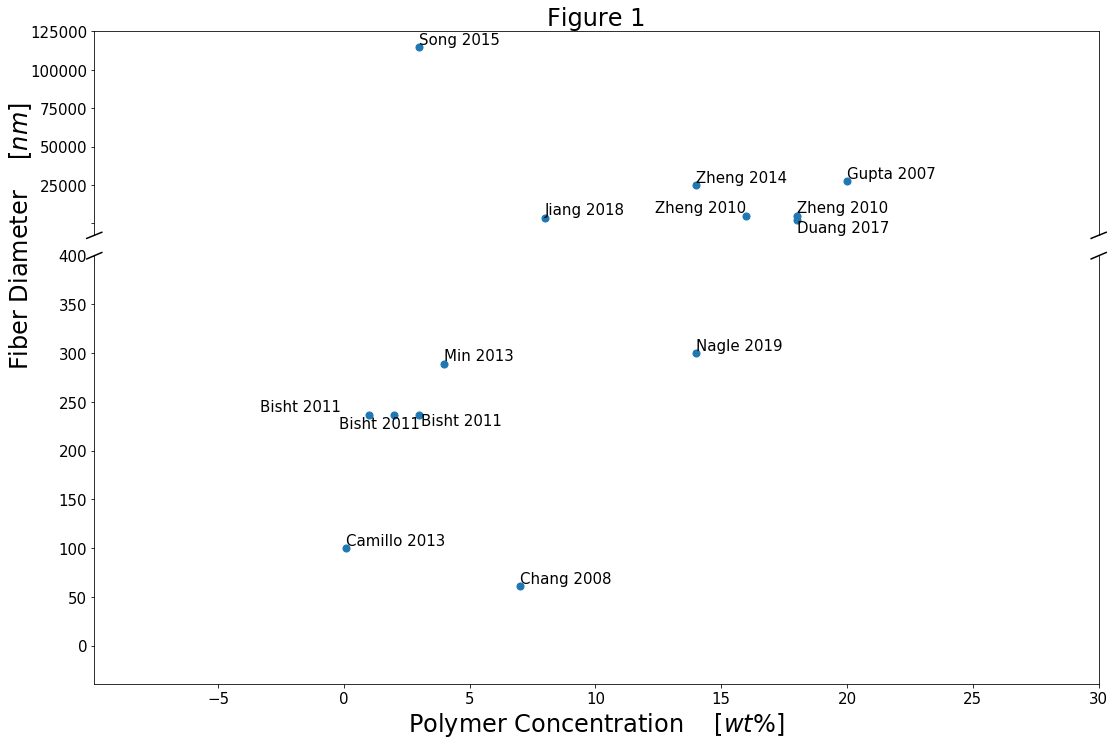

In [23]:
# PLOT FIG
fig_name = 'Figure 1';
x_str = 'Polymer Concentration'; x_units = r'$[wt\%]$';
y_str = 'Fiber Diameter'; y_units = r'$[nm]$';
breakYlim = 7;

scatterPlot_breakAxis(x_str, x_units, y_str, y_units, df, df_x, fig_name, breakYlim);
#scatterPlot(x_str, x_units, y_str, y_units, df, 'original: ' + fig_name)

>>> new_df
    Nozzle Diameter  Fiber Diameter     Reference
31            100.0           61.00    Chang 2008
21            260.0          100.00  Camillo 2013
30            210.0          237.00    Bisht 2011
19            100.0          289.26      Min 2013
40            250.0          300.00    Nagle 2019
7             260.0         2250.00    Duang 2017
10            210.0         3730.00    Jiang 2018
12             40.0         5150.00    Zheng 2010
39            210.0        25000.00    Zheng 2014
5             750.0        27500.00    Gupta 2007
20              2.0       115000.00     Song 2015


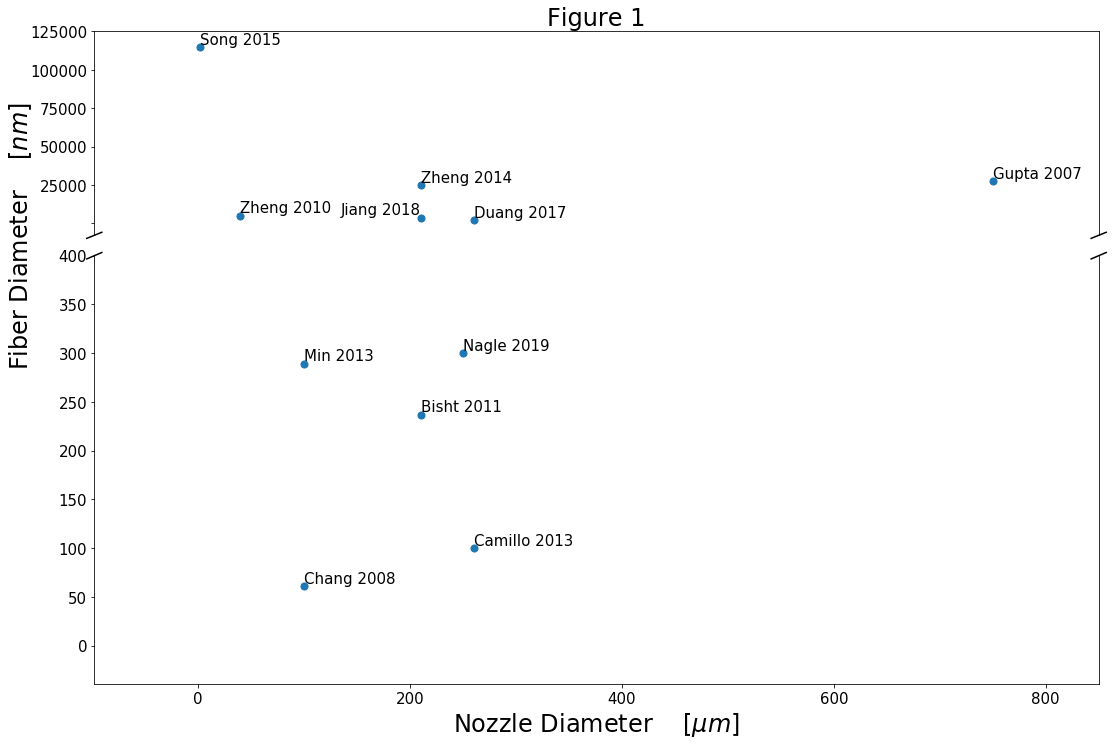

In [22]:
# PLOT FIG
fig_name = 'Figure 1';
x_str = 'Nozzle Diameter'; x_units = r'$[\mu m]$';
y_str = 'Fiber Diameter'; y_units = r'$[nm]$';
breakYlim = 5;

scatterPlot_breakAxis(x_str, x_units, y_str, y_units, df, df_x, fig_name, breakYlim);
#scatterPlot(x_str, x_units, y_str, y_units, df, 'original: ' + fig_name)

>>> new_df
    Nozzle to Collector Distance  Fiber Diameter     Reference
31                          0.50           61.00    Chang 2008
21                          0.50          100.00  Camillo 2013
30                          1.00          237.00    Bisht 2011
19                          2.50          289.26      Min 2013
40                          5.25          300.00    Nagle 2019
7                          30.00         2250.00    Duang 2017
10                          2.00         3730.00    Jiang 2018
12                          1.00         5150.00    Zheng 2010
39                          2.00        25000.00    Zheng 2014
5                           1.25        27500.00    Gupta 2007
20                         30.00       115000.00     Song 2015


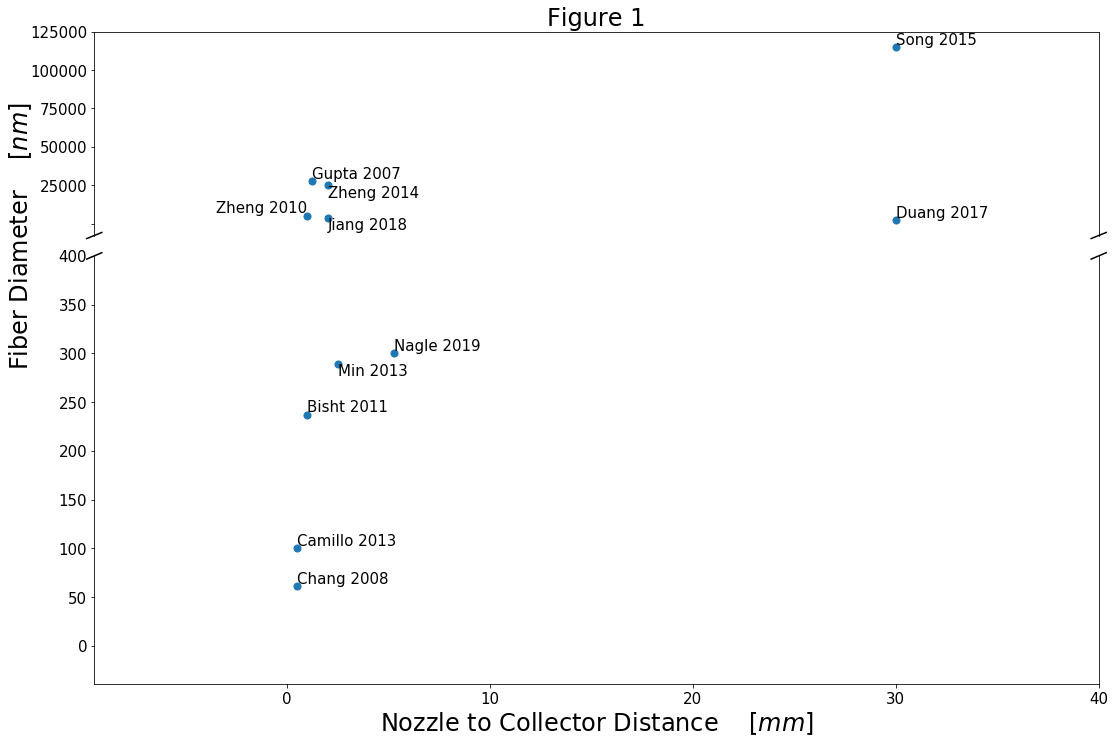

In [21]:
# PLOT FIG
fig_name = 'Figure 1';
x_str = 'Nozzle to Collector Distance'; x_units = r'$[mm]$';
y_str = 'Fiber Diameter'; y_units = r'$[nm]$';
breakYlim = 5;

scatterPlot_breakAxis(x_str, x_units, y_str, y_units, df, df_x, fig_name, breakYlim);
#scatterPlot(x_str, x_units, y_str, y_units, df, 'original: ' + fig_name)